Maddie's portions of the final presentation notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from processing import *
from visualization import *
from sample import sample

In [2]:
image = np.load('image2.npy')
im = sample(image, 32)

In [10]:
W, H = run_nmf(im, 2)

## Motivations

Photo-induced force microscopy is a tool often used to visualize a variety of materials and how those materials' topographies, absorptions, and emissions behave under different excitation wavelengths.

Analysis of PiFM images relies on major assumptions:
- The ratio of the prepared solutions or samples is maintained post-preparation and during measurement
- Spectra of individual components can be parsed out of a spectrum of the mixed sample

A variety of techniques have been used to probe these assumptions, including Principal Component Analaysis and Principal Component Regression. These techniques allow us to better understand if intended ratios are maintained, how well mixed samples behave, and how sample preparation or sample interactions might affect spectra.

## So, what is NMF?

Non-negative Matrix Factorization (NMF) is a technique that has a variety of applications. It's most common application is in image analysis.

NMF approximates matrix $X$ by decomposing it into component matrices $W$ and $H$.

<h1><center>$X = WH$</center></h1>

The $W$ matrix is often considered the *weight* matrix while the $H$ matrix contains the given number of *components*.



(-0.5, 1524.5, 735.5, -0.5)

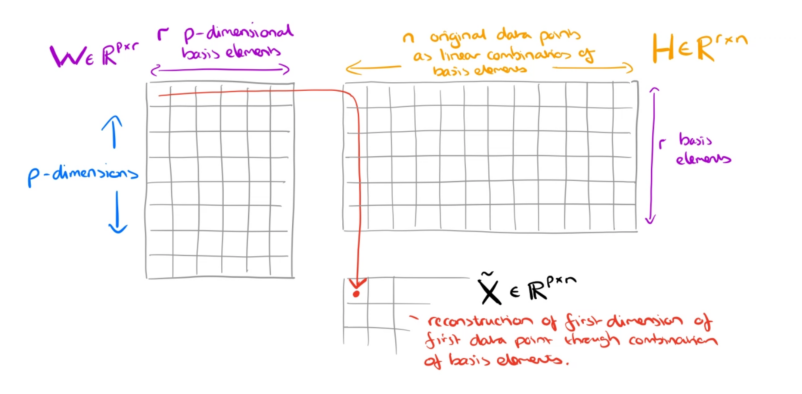

In [17]:
fig, ax = plt.subplots(figsize = (18,7))
figure = plt.imread('nmf.PNG')
ax.imshow(figure)
ax.axis('off')

[Source for image.](https://blog.acolyer.org/2019/02/18/the-why-and-how-of-nonnegative-matrix-factorization/)

Our goal: Given a hyperspectral image (stacks of many images taken at different excitation wavenumbers), what are the weight matrices and component spectra of a mixed polymer sample?

How NMF helps:
- Non-negativitiy applied to all components (no such thing as a negative polymer!)
- Highly custommizable for >2 polymer blends

## Datasets

We'll be focusing on *hyperspectral* data sets. We often refer to these as data cubes. Essentially, for each excitation wavenumber of a given range, we take an image of our sample. You can imagine these images stacked on top of each other with the same x,y coordinates but different intensity values.

In [5]:
interactive_hyperimage(im)

interactive(children=(IntSlider(value=1313, description='a', max=1877, min=750), Output()), _dom_classes=('wid…

<function visualization.interactive_hyperimage.<locals>.update(a)>

## check_comps function

How can we assign NMF component spectra to ground truths?

First, let's get initialize a **dictionary** of our ground truth spectra.

In [7]:
ps_truth = np.load('ps_ground_truth.npy')
dppdtt_truth = np.load('dppdtt_ground_truth.npy')

ps = np.interp(ps_truth, (ps_truth.min(), ps_truth.max()), (0,1))
dppdtt = np.interp(dppdtt_truth, (dppdtt_truth.min(), dppdtt_truth.max()), (0,1))

truths = {'ps': ps, 'dppdtt': dppdtt}

Let's look at the logic inside `check_comps(comps, truths)`:

`matches = {}

    for i in range(comps.shape[0]):
        comps[i,:] = np.interp(comps[i,:], (comps[i,:].min(), comps[i,:].max()), (0,1))

    for key in truths:
        matches[key] = {'truth':truths[key],
                        'NMF':None,
                        'RMSE':None,
                        'Index':None}
    rmse_vals = {}

    for key in truths:
        rmse_vals[key] = {}
        for i in range(comps.shape[0]):
            rmse_vals[key][i] = mean_squared_error(truths[key], comps[i,:], squared = False)

    for i in range(comps.shape[0]):
        val = 1000000000
        min_key = None
        for key in truths: 
            if val > rmse_vals[key][i]:
                val = rmse_vals[key][i]
                min_key = key
            else:
                pass
        matches[min_key]['NMF'] = comps[i,:]
        matches[min_key]['RMSE'] = val
        matches[min_key]['Index'] = i

    return matches`

So, with each step, we are minimizing the RMSE between the NMF component and ground truth.

In [13]:
matches = check_comps(H, truths)

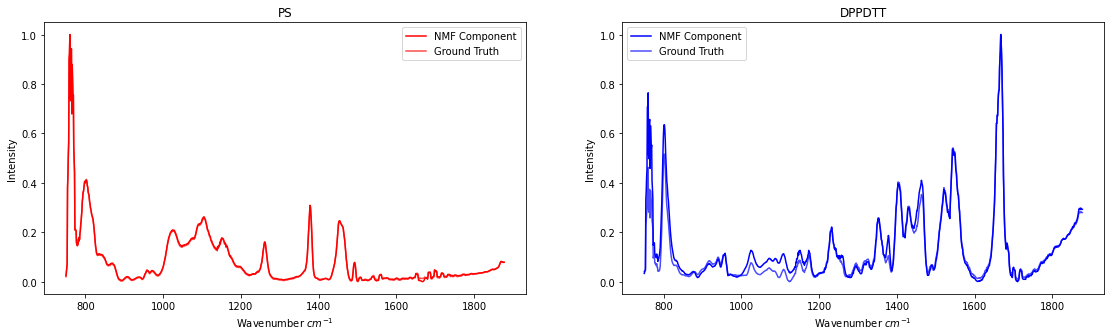

In [21]:
fig, ax = plt.subplots(ncols = 2, figsize = (19,5))

x = np.arange(750,1878)

ax[0].plot(x, matches['ps']['NMF'], color = 'red', label = 'NMF Component')
ax[0].plot(x, matches['ps']['truth'], color = 'red', alpha = 0.7, label = 'Ground Truth')
ax[0].set_xlabel('Wavenumber $cm^{-1}$')
ax[0].set_ylabel('Intensity')
ax[0].set_title('PS')
ax[0].legend()

ax[1].plot(x, matches['dppdtt']['NMF'], color = 'blue', label = 'NMF Component')
ax[1].plot(x, matches['dppdtt']['truth'], color = 'blue', alpha = 0.7, label = 'Ground Truth')
ax[1].set_xlabel('Wavenumber $cm^{-1}$')
ax[1].set_ylabel('Intensity')
ax[1].set_title('DPPDTT')
ax[1].legend()

plt.show()

Our spectra match! Looks like NMF did a good job decomposing the original image and our `check_comps` function was able to correctly identify which is which!

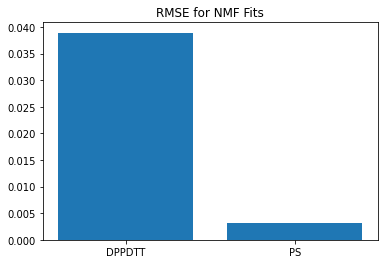

In [22]:
plt.bar([0.5, 1.5],[matches['dppdtt']['RMSE'], matches['ps']['RMSE']])
plt.xticks([0.5,1.5], ['DPPDTT', 'PS'])
plt.title('RMSE for NMF Fits')
plt.show()

In addition to the ground truths, NMF components, and RMSE values saved in the `matches` dictionary, we also have a key for the *index* of the matched component. We can use that same index to parse through the W matrix.

## Building on this Project in the *Future*!

- modifying the `check_comps` function to take .json files instead of dictionaries of ground truths
- "Classifying" the package, or turning hyperspectral images into Classes with the analyses functions given above acting as methods
- making a pip installable package
- internally normalizing for intensity markers